# Custom Facial Verification Project

## 1. Import data from github

In [ ]:
!git clone https://github.com/liem18112000/facemask_data.git

Cloning into 'facemask_data'...
remote: Enumerating objects: 23678, done.
remote: Total 23678 (delta 0), reused 0 (delta 0), pack-reused 23678
Receiving objects: 100% (23678/23678), 1.24 GiB | 48.66 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Checking out files: 100% (23675/23675), done.


In [ ]:
!nvidia-smi

Tue Feb  2 02:37:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Import libraries and create global parameters

In [ ]:
# Import libs
import numpy as np
import tensorflow as tf
import shutil
import os
import random
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path

# Global variables
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = [224, 224, 3]
TRAIN_SIZE = 1000 
TEST_SIZE = 80
EPOCH = 10

# Pretrained model selection
'''
    "VGG19"             :   Very Deep Convolutional Networks for Large-Scale Image Recognition (ICLR 2015)
    "MobileNetV2"       :   MobileNetV2: Inverted Residuals and Linear Bottlenecks (CVPR 2018)
    "ResNet152V2"       :   Identity Mappings in Deep Residual Networks (CVPR 2016)
    "Xception"          :   Xception: Deep Learning with Depthwise Separable Convolutions (CVPR 2017)
    "InceptionResNetV2" :   Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning (AAAI 2017)
    "DenseNet201"       :   Densely Connected Convolutional Networks (CVPR 2017)
'''
selected_models = [
    "VGG19",
    "MobileNetV2",
    # "ResNet152V2",
    # "Xception",
    # "InceptionResNetV2",
    # "DenseNet201"
]

## 3. Create directory for allocating data

In [ ]:
# All classes
classes = [
    'Mask',
    'No Mask',
    'Wrong Mask'
]

# Assigning data paths to variables
root_dir = 'facemask_data/mask/';

for cls in classes:

    # Get data dir
    data = root_dir  + cls + "/"

    # The overall info of data in facemask_data
    total_images = os.listdir(data)
    print("Number of " + cls + "'s images : {}".format(len(total_images)))

    # Check whether train - test directories are created or not
    if(not path.isdir('./train/' + cls)):

        os.makedirs('./train/' + cls)
        print('Created directory "{}"'.format('./train/' + cls))

        os.makedirs('./test/' + cls)
        print('Created directory "{}"'.format('./test/' + cls))

        for image in random.sample(total_images, TRAIN_SIZE):
            shutil.copy(data + image, './train/' + cls)

        for image in random.sample(total_images, TEST_SIZE):
            shutil.copy(data + image, './test/' + cls)

    else:
        print('Directories : "' + cls + '" already created!')

Number of Mask's images : 1175
Created directory "./train/Mask"
Created directory "./test/Mask"
Number of No Mask's images : 1083
Created directory "./train/No Mask"
Created directory "./test/No Mask"
Number of Wrong Mask's images : 1415
Created directory "./train/Wrong Mask"
Created directory "./test/Wrong Mask"


## 4. Train - test data separation

In [ ]:
# Data is separated into train, test datasets + normailzation + Random noises
train_batch = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, shear_range=0.2).\
            flow_from_directory('./train', target_size=IMAGE_SIZE, batch_size=10, class_mode = 'categorical')
test_batch = ImageDataGenerator(rescale=1./255).\
            flow_from_directory('./test', target_size = IMAGE_SIZE, batch_size=10, class_mode= 'categorical')


Found 2998 images belonging to 3 classes.
Found 240 images belonging to 3 classes.


## 5. Build Models

### a. Pre-trained model initialize

In [ ]:
# Import desired pretrained models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import DenseNet201

# Call explicit prtetrained models
pretrained_models = {
    "VGG19"             :   VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False),
    "MobileNetV2"       :   MobileNetV2(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False),
    "ResNet152V2"       :   ResNet152V2(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False),
    "Xception"          :   Xception(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False),
    "InceptionResNetV2" :   InceptionResNetV2(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False),
    "DenseNet201"       :   DenseNet201(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
}

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
# Set pretrain model to untrainable 
for (key, model) in pretrained_models.items():
    if key in selected_models:
        for layers in model.layers:
            layers.trainable = False

        # Overal infomation of pretrain model
        print("Overall infomation of pretrain model '" + key + "' :")
        model.summary()

Overall infomation of pretrain model 'VGG19' :
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

### b. Complete overall model for facemask detection

In [ ]:
# Construct model for detection
complete_models = {} 

for (key, value) in pretrained_models.items():
    if key in selected_models: 
        model = tf.keras.models.Sequential([
                    value,
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(4096, activation='relu'),
                    tf.keras.layers.Dense(1024, activation='relu'),
                    tf.keras.layers.Dense(len(classes), activation='softmax')
                ])
        complete_models.update({
            key :  model
        })

        # Overall information of model
        print('Over model of ' + key + ' - FC')
        model.summary()

Over model of VGG19 - FC
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 126,987,331
Trainable params: 106,962,947
Non-trainable params: 20,024,384
________

## 6. Model training and evaluation

In [ ]:
histories = {}

for (key, model) in complete_models.items():

    print('Model "' + key + '" training : ')

    # Complie model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Train model
    history = model.fit(train_batch, validation_data=test_batch, epochs=EPOCH)

    # History update
    histories.update({
        key : history
    })

Model "VGG19" training : 
Epoch 1/10
 41/300 [===>..........................] - ETA: 1:03 - loss: 12.2752 - accuracy: 0.4106

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


300/300 [==============================] - 82s 246ms/step - loss: 3.5527 - accuracy: 0.6252 - val_loss: 0.3755 - val_accuracy: 0.8542
Epoch 2/10
300/300 [==============================] - 73s 244ms/step - loss: 0.4218 - accuracy: 0.8473 - val_loss: 0.2826 - val_accuracy: 0.8708
Epoch 3/10
300/300 [==============================] - 73s 244ms/step - loss: 0.3506 - accuracy: 0.8572 - val_loss: 0.3077 - val_accuracy: 0.8667
Epoch 4/10
300/300 [==============================] - 74s 247ms/step - loss: 0.3414 - accuracy: 0.8751 - val_loss: 0.2802 - val_accuracy: 0.9000
Epoch 5/10
300/300 [==============================] - 73s 245ms/step - loss: 0.2954 - accuracy: 0.8860 - val_loss: 0.1850 - val_accuracy: 0.9375
Epoch 6/10
300/300 [==============================] - 73s 245ms/step - loss: 0.2981 - accuracy: 0.8871 - val_loss: 0.2451 - val_accuracy: 0.9125
Epoch 7/10
300/300 [==============================] - 73s 243ms/step - loss: 0.2589 - accuracy: 0.8964 - val_loss: 0.1681 - val_accuracy: 0.9

Train accuracy of VGG19 :


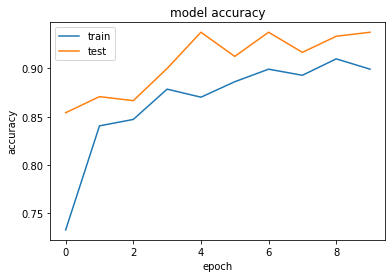

Loss of VGG19 :


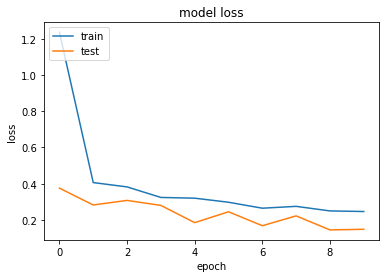

Train accuracy of MobileNetV2 :


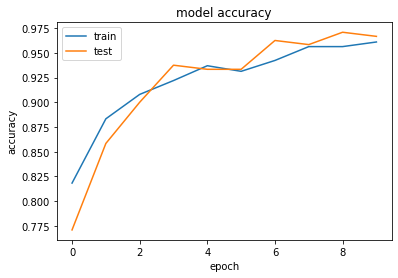

Loss of MobileNetV2 :


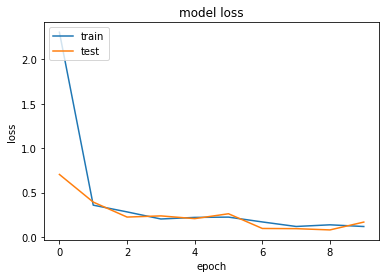

In [ ]:
for (key, history) in histories.items():

    print("Train accuracy of " + key + " :")

    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # Show plots 
    plt.show()

    print("Loss of " + key + " :")

    # summarize history for loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # Show plots 
    plt.show()

In [ ]:
for (key, model) in complete_models.items():

    # Model evaluation
    print("Evaluate on test set : ")
    results = model.evaluate(test_batch, batch_size=128)
    print("Model '" + key + "' accuracy : ", results[1] * 100, "%")

Evaluate on test set : 
24/24 [==============================] - 4s 155ms/step - loss: 0.1483 - accuracy: 0.9375
Model 'VGG19' accuracy :  93.75 %
Evaluate on test set : 
24/24 [==============================] - 4s 150ms/step - loss: 0.1672 - accuracy: 0.9667
Model 'MobileNetV2' accuracy :  96.66666388511658 %


## 7. Save model

In [ ]:
model_dir = 'trained_model'

for (key, model) in complete_models.items():

    # Save model - h5 format
    file = model_dir + '/' + key + 'me_verification.h5'
    model.save(file)
    print('Save model to : ' + str(file))

Save model to : trained_model/VGG19me_verification.h5
Save model to : trained_model/MobileNetV2me_verification.h5


In [ ]:
# JSON format for web application
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras trained_model/VGG19me_verification.h5 compliled_model/VGG19me_verification

     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 112kB 10.3MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0
2021-02-02 03:04:08.206337: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
